## Dependency

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device: {device}')

res_scale = .1

Using device: cpu


## PINN

In [25]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 24).double()
        self.hidden_layer2 = nn.Linear(24, 24).double()
        self.hidden_layer3 = nn.Linear(1, 13).double()
        self.hidden_layer4 = nn.Linear(24, 13).double()

        self.hidden_layer5 = nn.Linear(13, 13).double()
        self.hidden_layer6 = nn.Linear(13, 13).double()
        self.hidden_layer7 = nn.Linear(13, 7).double()
        self.hidden_layer8 = nn.Linear(13, 7).double()

        self.hidden_layer9 = nn.Linear(7, 7).double()
        self.hidden_layer10 = nn.Linear(7, 7).double()
        self.hidden_layer11 = nn.Linear(7, 1).double()
        self.hidden_layer12 = nn.Linear(7, 1).double()
    
        
    def forward(self, y):
        res = torch.sin(self.hidden_layer1(y))
        res = torch.tanh(self.hidden_layer2(res))
        y = self.hidden_layer3(y) + res_scale * self.hidden_layer4(res)

        res = torch.sin(self.hidden_layer5(y))
        res = torch.tanh(self.hidden_layer6(res))
        y = self.hidden_layer7(y) + res_scale * self.hidden_layer8(res)

        res = torch.sin(self.hidden_layer9(y))
        res = torch.tanh(self.hidden_layer10(res))
        y = self.hidden_layer11(y) + res_scale * self.hidden_layer12(res)
        return y
    
    def U(self, y):
        return (self(y) - self(-y)) / 2

    def get_lam(self):
        y = torch.linspace(-2,2,10,dtype=torch.float64).view(-1,1).to(device)
        y.requires_grad = True
        U = self.U(y)
        U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
        # U_yy = torch.autograd.grad(U_y, y, grad_outputs=torch.ones_like(U_y), create_graph=True)[0]
        # return torch.mean(torch.divide(-(1 + U_y) * U_y - (U + y) * U_yy, y * U_yy))
        return torch.mean(torch.divide((y + U) * U_y,U - y * U_y))
    def get_fixed_lam(self):
        return .5
    
def f(y,U,U_y,lam):
    return -lam * U + ((1 + lam) * y + U) * U_y

def compute_derivative(f, y, model, lam, orders,finite=False):
    y.requires_grad = True
    U = model.U(y)
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    lam = model.get_lam()
    f_val = f(y, U, U_y, lam)
    h = y[1] - y[0]
    res = []
    if not finite:
        for _ in range(int(orders.max())):
            f_val = torch.autograd.grad(f_val, y, grad_outputs=torch.ones_like(f_val), create_graph=True)[0]
            if _ + 1 in orders:
                res.append(f_val)
    else:
        for _ in range(int(orders.max())):
            f_val = (f_val[1:] - f_val[:-1]) / h
            if _ + 1 in orders:
                res.append(f_val)
    return res

# @torch.compile
def Loss(model, y, collocation_points,mode,step):
    y.requires_grad = True
    U = model.U(y)
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    # U_yy = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True,retain_graph=)[0]
    if mode == 'fixed':
        lam = model.get_fixed_lam()
    if mode == 'learned':
        lam = model.get_lam()


    # Equation loss
    f_val = f(y, U, U_y,lam)

    # Smooth loss 3rd and fifth derivative
    derivatives = compute_derivative(f,collocation_points,model,lam, orders=np.array([3.0]),finite=True)
    f_yyy = derivatives[0]
    #f_yyyyy = derivatives[1]
 

    # Condition loss U(-2) = 1
    g = model.U(torch.tensor([-2.0], dtype=y.dtype, device=y.device)) - 1
    
    equation_loss = torch.mean(f_val**2)
    condition_loss = torch.mean(g**2)

   # experiment_loss = torch.exp(torch.tensor(data=[-0.5],dtype=torch.float64) * step + torch.tensor(data=[1],dtype=torch.float64)) * torch.mean(U_y**2)
    total_loss = equation_loss + condition_loss + 1e-3*torch.mean(f_yyy**2) #+ 1e-10*torch.mean(f_yyyyy**2) 
    return total_loss

## Trainning

### Fixed lambda 

In [26]:
model = PINN().to(device)
model = torch.compile(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

'''
 Load the model if needed
'''
# model.load_state_dict(torch.load('model.pth'))
# optimizer.load_state_dict(torch.load('optimizer.pth'))
# model.eval()  
# model.train()  

num_epochs = 10000
y_data = torch.linspace(1,2,1000,dtype=torch.float64).view(-1,1).to(device)
# y_data = (y_data-y_data.mean()) / y_data.std()

# writer = SummaryWriter()
Ns = 1000
collocation_points = torch.FloatTensor(Ns).uniform_(-1, 1).view(-1, 1).double().to(device)
collocation_points = (collocation_points-collocation_points.mean()) / collocation_points.std()

def closure(step):
    optimizer.zero_grad() # Clear the gradients
    loss = Loss(model, y_data,collocation_points,'fixed',step) # Compute the loss
    loss.backward() # Backward pass
    return loss

for epoch in range(num_epochs):
    # y_data = torch.FloatTensor(10000).uniform_(-2, 2).view(-1, 1).to(device)

    optimizer.zero_grad()
    loss = Loss(model, y_data, collocation_points,'fixed',epoch)
    loss.backward()
    optimizer.step(lambda:closure(epoch))
    if epoch % 100 == 0:
        print(f'epoch {epoch} loss {loss.item()}') 
    # writer.add_scalar(f'Training Loss_1', loss.item(), epoch)
    if loss.item() <= 1e-12:
        break

epoch 0 loss 1.2485616589233688
epoch 100 loss 0.012763528238506634
epoch 200 loss 0.00014853945482685385
epoch 300 loss 5.394163900539993e-05
epoch 400 loss 1.3546386005348731e-05
epoch 500 loss 3.0472480388219373e-06
epoch 600 loss 1.3097166264616614e-06
epoch 700 loss 1.1098366246890037e-06
epoch 800 loss 1.0860592471177028e-06
epoch 900 loss 1.0757135655254532e-06
epoch 1000 loss 1.0656233739933327e-06
epoch 1100 loss 1.05507627633649e-06
epoch 1200 loss 1.0440738805441297e-06
epoch 1300 loss 1.0326414324380247e-06
epoch 1400 loss 1.020800465743961e-06
epoch 1500 loss 1.008568587262456e-06
epoch 1600 loss 9.959599786328325e-07
epoch 1700 loss 9.829859162851158e-07
epoch 1800 loss 9.696553074022098e-07
epoch 1900 loss 9.559752400559387e-07
epoch 2000 loss 9.41951539789387e-07
epoch 2100 loss 9.275893213755337e-07
epoch 2200 loss 9.128935224697186e-07
epoch 2300 loss 8.978694051228228e-07
epoch 2400 loss 8.825230115032048e-07
epoch 2500 loss 8.668615615830454e-07
epoch 2600 loss 8.50

### Lambda learned in the process

In [ ]:
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

num_epochs = 1000
y_data = torch.linspace(1,2,1000,dtype=torch.float64).view(-1,1).to(device)
# y_data = (y_data-y_data.mean()) / y_data.std()

# writer = SummaryWriter()
Ns = 1000
collocation_points = torch.FloatTensor(Ns).uniform_(-1, 1).view(-1, 1).double().to(device)
collocation_points = (collocation_points-collocation_points.mean()) / collocation_points.std()

def closure(step):
    optimizer.zero_grad() # Clear the gradients
    loss = Loss(model, y_data,collocation_points,'learned',step) # Compute the loss
    loss.backward() # Backward pass
    return loss

for epoch in range(num_epochs):
    # y_data = torch.FloatTensor(10000).uniform_(-2, 2).view(-1, 1).to(device)

    optimizer.zero_grad()
    loss = Loss(model, y_data, collocation_points,'learned',epoch)
    loss.backward()
    optimizer.step(lambda:closure(epoch))
    if epoch % 100 == 0:
        print(f'epoch {epoch} loss {loss.item()/1e}') 
    # writer.add_scalar(f'Training Loss_1', loss.item(), epoch)
    if loss.item() <= 1e-8:
        break

Inferred lambda is 0.5194008423402316
Residual is 0.0077987912992273966


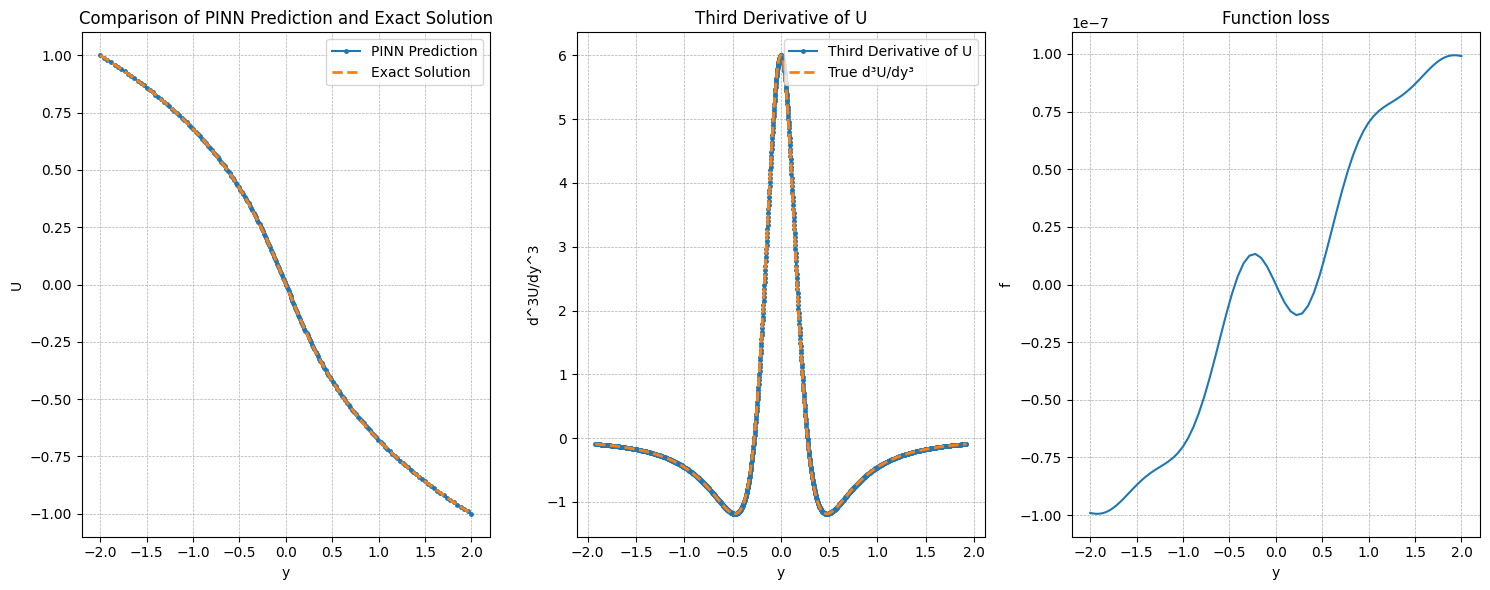

In [ ]:
y_test = 2*torch.sin(torch.linspace(-np.pi/2, np.pi/2, 100)).view(-1, 1).double().to(device)
y_test.requires_grad = True
# Get model predictions and detach to move to CPU
U_pred = model.U(y_test)
U_pred_y = torch.autograd.grad(U_pred, y_test, grad_outputs=torch.ones_like(U_pred), create_graph=True)[0]
U_pred_yy = torch.autograd.grad(U_pred_y, y_test, grad_outputs=torch.ones_like(U_pred_y), create_graph=True)[0]
U_pred_yyy = torch.autograd.grad(U_pred_yy, y_test, grad_outputs=torch.ones_like(U_pred_yy), create_graph=True)[0]
U_pred_yyyy = torch.autograd.grad(U_pred_yyy, y_test, grad_outputs=torch.ones_like(U_pred_yyy), create_graph=True)[0]
U_pred_yyyyy = torch.autograd.grad(U_pred_yyyy, y_test, grad_outputs=torch.ones_like(U_pred_yyyy), create_graph=True)[0]

lam = model.get_lam().detach().cpu().numpy()
print(f'Inferred lambda is {lam}')
residual = f(y_test,U_pred,U_pred_y,lam)
print(f'Residual is {torch.sqrt(torch.mean(residual**2))}')
U_pred = U_pred.detach().cpu().numpy()
# Generate exact solution using implicit formula
U_positive = np.linspace(0, 1, 100)
y_true = np.array([U_positive + U_positive**(1 + 1/lam), -U_positive - U_positive**(1 + 1/lam)]).flatten()
order = y_true.argsort()
U_sorted = np.array([-U_positive, U_positive]).flatten()[order]

y_sorted = y_true[order]

# Convert test data to numpy
y_test_np = y_test.detach().cpu().numpy()

# === Compute true solution and its third derivative ===
U_pos = np.linspace(-1, 1, 1000)
y_neg = -U_pos - U_pos**(1 + 1 / .5)

# Odd symmetry extension
U_full = U_pos
y_full = y_neg

# Sort the data
sort_idx = np.argsort(y_full)
y_sorted_true = y_full[sort_idx]
U_sorted_true = U_full[sort_idx]

# Compute numerical derivatives
dU_dy_true = np.gradient(U_sorted_true, y_sorted_true)
d2U_dy2_true = np.gradient(dU_dy_true, y_sorted_true)
d3U_dy3_true = np.gradient(d2U_dy2_true, y_sorted_true)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

# Plot the PINN Prediction vs Exact Solution
ax1.plot(y_test_np, U_pred_yyy, '.-', label='PINN Prediction', color='#1f77b4', markersize=5)
ax1.plot(y_sorted, U_sorted, label='Exact Solution', color='#ff7f0e', linestyle='--', linewidth=2)
ax1.set_title('Comparison of PINN Prediction and Exact Solution')
ax1.set_xlabel('y')
ax1.set_ylabel('U')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Plot the third derivative
ax2.plot(y_sorted_true[10:-10], d3U_dy3_true[10:-10], '.-', label='Third Derivative of U', color='#1f77b4', markersize=5)
ax2.plot(y_sorted_true[10:-10], d3U_dy3_true[10:-10], label='True d³U/dy³', color='#ff7f0e', linestyle='--', linewidth=2)

ax2.set_title('Third Derivative of U')
ax2.set_xlabel('y')
ax2.set_ylabel('d^3U/dy^3')
ax2.grid(True, which='both', linestyle='--', linewidth=0.51)
ax2.legend()

ax3.plot(y_test_np, residual.detach().numpy() )

ax3.set_title('Function loss')
ax3.set_xlabel('y')
ax3.set_ylabel('f')
ax3.grid(True, which='both', linestyle='--', linewidth=0.51)

plt.tight_layout()
plt.show()

In [ ]:
# Save the model 
model_path = 'model_nbatch_first.pth'
optimizer_path = 'optimizer_nbatch_first.pth'

torch.save(model.state_dict(), model_path)

torch.save(optimizer.state_dict(), optimizer_path)